## Computation for Dynamic Programming

An important part of applying dynamic programming (in macroeconomics) is learning to do computation. This series of classes shows how I learn to do just that. I use python, and its various tools for efficient computation/optimsition. I start with simple problems and build up complexity. As I do, we will run into computational challenges. Closer to the research frontier, dealing with these challenges becomes the majority of the game. 

This is not intended as an introduction to, nor rigorous mathematical treatment of, dynamic programming. I will often reference *Recursive Methods in Economic Dynamics*, written by Stokey, Lucas, and Prescott---three greats in modern macro! I'll refer to it as SLP and refer the reader to it when I invoke important results/ideas. Despite being well-known for being tough, the explanations of the topic are by far the clearest I have found.  

Mostly, we will consider infinite horizon problems. This is because in finite horizons agents simply go to the "end of time" and, by backwards , unravel the problem. In most contexts, this will be unsatisfactory.

Good luck! I hope you find it reassuring to know that I have struggled through the examples I compute in this series of classes...Unfortunately, this is the only way to learn. I highly encourage the reader to code these examples, and others in the spirit of *Example 3* from scratch. Again, this is the only way to learn.

## Class 1 Objectives

1. Learn how to do value function iteration with grid discretisation, both in deterministic and stochastic economies.
2. Collect a list of "problems" we encounter to tackle in future classes.

## Example 1: The Cake-Eating Problem

This is the simplest possible "savings" problem one can pose. Suppose an agent begins life with a cake of size $w_0$ at $t=0$. They then must choose how much of it to consume until they die. That is, the Bellman equation is: 

$$V(w) = \max_{w' \in [0,w]} \bigg\{ u(w-w')+\beta V(w') \bigg\}$$

Notice, I take consumption out of the problem because once tomorrow's cake size is chosen the amount consumed is pinned down (assuming no waste). I will assume $u(c) = \ln(c)$. 

[CITE SOME SLP CONDITIONS]

The steps I follow below are the most basic value function iteration (VFI). I guess the value function "blindly" with $V_0(w)=0$. With a more informed guess computation would be quicker. I then set in motion an iteration. The great thing about VFI is that we have a uniqueness theorem; we know that this numerical procedure will get us arbitrarily close to the unique true value function. For more complex problems, this won't be comforting because computation to get us reasonably close to a solution will be too costly. But we will cross that bridge when we get there...

In this example, the state space is continuous. Over continuous state spaces numerical methods provide an approximation in the sense that we can only compute values at discrete grid points. Another way of saying the same thing: we can only compute a finite number of points! A consequence of discretisation this way is that we constrain the policy function $w'(w)$ to take the exact values on the grid. This is the first in our list of problems we will come back to in future classes.

The VFI below shows that in about 30 seconds we can approximate a solution to the problem using pretty tractable code. In this case, we have an analytical benchmark we can compare the numerical solution to. 

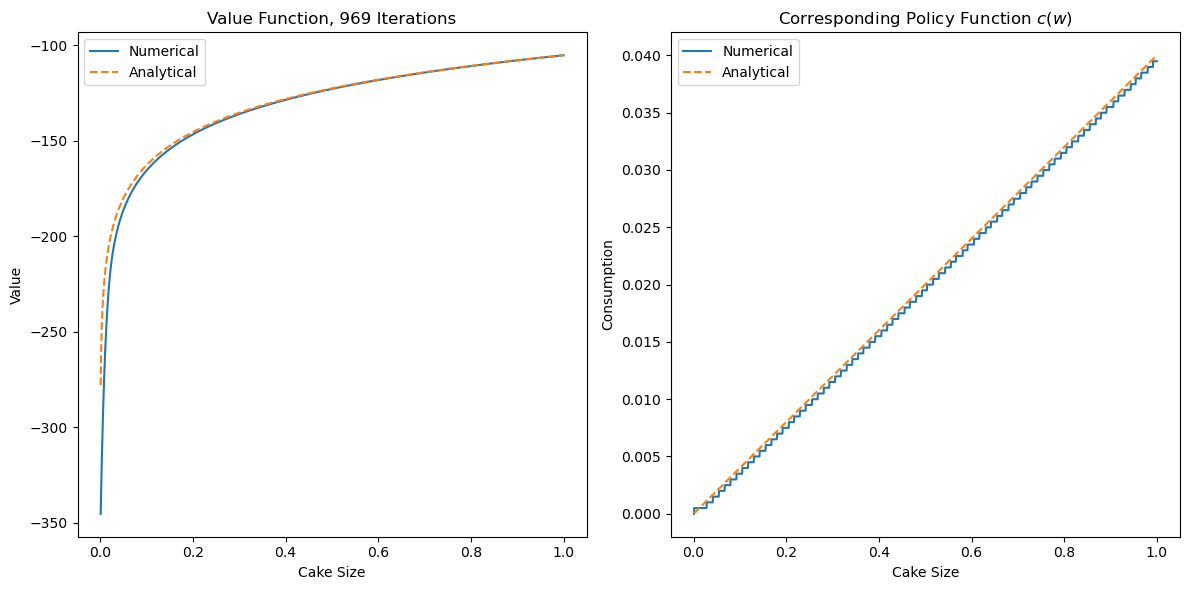

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class CakeEatingModel:
    def __init__(self, grid_size=1000, beta=0.96, cake_size=1.0):
        # choose parameters
        self.grid_size = grid_size
        self.beta = beta
        self.cake_size = cake_size
        
        # discretise the w grid
        self.grid = np.linspace(1e-3, cake_size, grid_size)
        self.U = self._compute_utility_matrix()
        
        # placeholders for outputs
        self.V = None
        self.c = None
        self.iter_count = 0

    # define the consumption function 
    def _utility(self, cons):
        # forbid the use of 0 by using a small pos number 
        cons = np.maximum(cons, 1e-6)
        return np.log(cons)

    # define the utility matrix
    def _compute_utility_matrix(self):
        grid = self.grid
        grid_length = self.grid_size
        
        # create utilities of -infs
        U = np.full((grid_length, grid_length), -np.inf)
        
        # loop over the grid
        for i in range(grid_length):
            # loop over valid parts of the grid (lower triangle)
            for j in range(i + 1):
                # calculate the utility
                U[i, j] = self._utility(grid[i] - grid[j])
        return U

    # define the VFI function
    def solve(self, threshold=1e-16):
        # initialise the error 
        error = 1 + threshold
        # initalise counter
        self.iter_count = 0
        # initialise the value function 
        V_old = np.zeros(self.grid_size)

        # define value function iteration loop
        while error > threshold:
            # calculate RHS of the Bellman equation
            # use np.newaxis to make a 2D row vector to allow broadcasting
            bellman_rhs = self.U + self.beta * V_old[np.newaxis, :]
            
            # calculate the new value function
            # np.max returns maximum value per row
            V_new = np.max(bellman_rhs, axis=1)
            
            # index for next period cake size
            w_next_index = np.argmax(bellman_rhs, axis=1)
            
            # calculate the implied consumption function
            c_new = self.grid - self.grid[w_next_index]
            
            # break if the value function converges
            if np.max(np.abs(V_new - V_old)) < threshold:
                break
            
            # update the value function
            V_old = V_new
            # increase the iteration count
            self.iter_count += 1

        # save outputs
        self.V = V_new
        self.c = c_new
        return self.V, self.c, self.iter_count

    # plot the V(w) and c(w)
    def plot_solve(self):
        value_comp = (1 - self.beta) ** -1 * np.log(self.grid)
        policy_comp = (1 - self.beta) * self.grid
        
        # normalise value function
        i_match = np.argmax(self.grid)  # since w_grid goes from 0 to 1
        offset = self.V[i_match] - value_comp[i_match]  # shift both to agree at end
        V_analytical_shifted = value_comp + offset

        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.grid, self.V, label='Numerical')
        plt.plot(self.grid, V_analytical_shifted, '--', label='Analytical')
        plt.title(f'Value Function, {self.iter_count} Iterations')
        plt.xlabel('Cake Size')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.grid, self.c, label='Numerical')
        plt.plot(self.grid, policy_comp, '--', label='Analytical')
        plt.title(r'Corresponding Policy Function $c(w)$')
        plt.xlabel('Cake Size')
        plt.ylabel('Consumption')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # simulate the cake economy
    def simulate(self, T_max):
        if self.c is None:
            raise RuntimeError("Run .solve() before simulating.")

        # store the cake size
        w_sequence = np.zeros(T_max)
        # initial cake size
        current_cake = self.cake_size
        # first period cake size
        w_sequence[0] = current_cake

        # loop over time
        for t in range(1, T_max):
            # find the index of the current cake size
            index = np.searchsorted(self.grid, current_cake)
            # clamp to avoid index errors at edges
            index = min(index, self.grid_size - 1)
            # calculate the consumption
            consumption = self.c[index]
            # calculate the next period cake size
            next_cake = current_cake - consumption
            # store the next cake size
            w_sequence[t] = next_cake
            # update the current cake size
            current_cake = next_cake

        return w_sequence


# initialise
cake_vfi = CakeEatingModel(2000, 0.96,1)
cake_vfi.solve()
cake_vfi.plot_solve()



The value function is concave just as the utility function is. Moreover, the consumption function is a linear function of the current cake size. 

Because this world is non-stochastic, we can exactly simulate what will happen to the cake over a number of periods. Thisis what we do below.

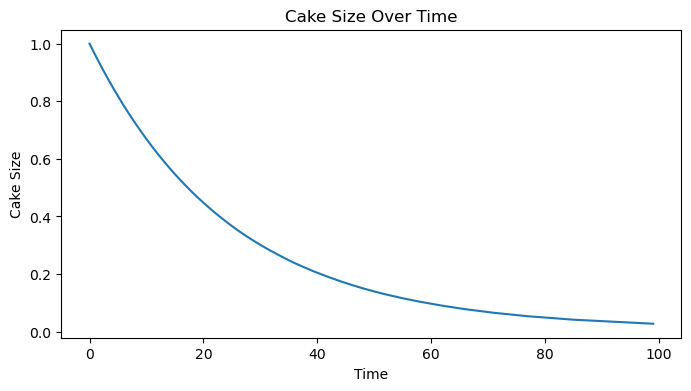

In [3]:
simulation = cake_vfi.simulate(100)

# plot the simulation
plt.figure(figsize=(8, 4))
plt.plot(simulation)
plt.title('Cake Size Over Time')
plt.xlabel('Time')
plt.ylabel('Cake Size')
plt.show()

In this cake eating problem, with the preferences specified, if the agent followed the computed policy function this is how the size of the cake will vary over time. This is pretty cool, with VFI we have made progress on this problem. Though it seems very simple, the heart of the decision in this problem is everywhere in economics: the trade-off between current and future consumption.

Now let's push what we have learned to apply to a more serious problem.

## Example 2: SP In a One Good Production Economy

### A Deterministic Economy

Suppose that there is one good $y_t$, which is produced by a unit mass of firms with a production function $y_t = F(k_t)$. That consumption good can be consumed or invested. There is a unit mass of consumers who with utility function $u(c_t), c_t \geq 0$. If invested, the good adds to the capital stock according to $i_t = k_{t+1} - (1-\delta) k_t$. $\delta \in (0,1)$ is the depreciation rate of capital. At the beginning of time, a capital stock $k_0$ is inherited.

This is a classic problem which embeds a similar dilemma to the cake-eating problem. Consume now or invest in production and consume more later. In addition, work more and have a greater supply of the good, at the cost of disliking that extra work. For now, we will pretend that a social planner chooses allocations to maximise consumer utility and does not need to bother about prices or interactions between agents. The goods resource constraint is: $c_t+\underbrace{k_{t+1} - (1-\delta) k_t}_{i_t} = F(k_t)$. For tidyness, $f(k_t) = (1-\delta)k_t+F(k_t)$: the total amount of the good available for consumption and capital investment. Similar to the cake-eating problem, we can remove consumption and investment so that the only choice variable is the amount of capital to have next period for production. The social planner's Bellman equation is: 

$$V(k) = \max_{k' \in [0, f(k)]} \bigg\{ u(f(k)-k') + \beta V(k') \bigg\}$$

This problem satisfies certain conditions, [INSERT SLP], which guarantee that VFI will converge towards the true value function and single-valued, continuous policy function, $k'(k)$.

We will attack the problem identically as the cake-eating problem. We will use the following functional forms:
- $F(k_t)=k_t^{\alpha}, \, \alpha  \in (0,1)$, the standard Cobb-Douglass production function

In this problem, knowing what to set as the grid is trickier. Before, the size of the cake we began with gave us a natural upper bound to discretise the grid. The upper bound for capital is not immediately obvious, even if there is a per period upper bound. By the properties of consumers, we do know that the SP will not simply accumulate/hoard capital. But the SP can accumulate capital stock over time if it is worth expanding the capital stock for future consumption. The way we will set the upper bound is by finding the steady state (SS) capital $k_{ss}$, and setting the upper limit as some reasonable multiple of it.

To find $k_{ss}$, we need the euler equation (EE). I write the partial derivate with a subscript in the variable the partial derivative is taken with respect to. It relies on an Envelope Theorem argument, but since it is easy to forget (I always do!), I will derive it from scratch. It is important and good practice to move between the Bellman equation and EEs anyway. Let $\mathcal{L}(k, k'(k))$ be the value function evaluated at the optimal points. We can take the partial derivative with respect to the control ($k'(k)$). But when taking a derivative with respect to the state $k$, we need to account for the fact that this is will endogeneously change the controls. Remembering what it means to take the total derivative:

$$ \frac{dV(k)}{dk} = \mathcal{L}_{k}(k,k'(k))+\mathcal{L}_{k'}(k,k'(k))k'_k(k)$$

But since $k'(k)$ are at their optimal points, $\mathcal{L}_{k'}(k,k'(k))=0$! Tomorrow's capital is chosen to maximise $\mathcal{L}$.

$$ \frac{dV(k)}{dk} = V_k(k) = \mathcal{L}_{k}(k,k'(k)) = u_c(f(k)-k')f_k(k)$$

Now take the FOC with respect to $k'$. Remember, $\mathcal{L}_k'(k,k'(k))=0$ because $k'$ is a one of the controls. This can be written: 

$$ \mathcal{L}_{k'}(k, k'(k)) = -u_c(f(k)-k')+\beta V_{k'}(k') =0$$

We can combine these two FOCs into one intertemporal equilibrium condition. The double dashes correspond to two periods ahead. The condition is,

$$ u_c(f(k)-k') = \beta u_c(f(k')-k'')f_{k'}(k')$$

Or, plugging in SS values and functional forms, 

$$1 = \beta(1-\delta + \alpha k_{ss}^{\alpha-1})$$

This gives us an analytical expression for the steady state of capital.

$$k_{ss} = \bigg( \frac{\alpha}{\beta^{-1}+\delta-1} \bigg)^{\frac{1}{1-\alpha}}$$

Even though this is a small and simple problem, I introduce how to use `njit` to speed up computation. `njit` uses faster C++ code to crank through loops in an efficient way. The tradeoff is that we must write our code in `njit`-friendly ways, which most of the time involves specifying loops with minimal helper functions.



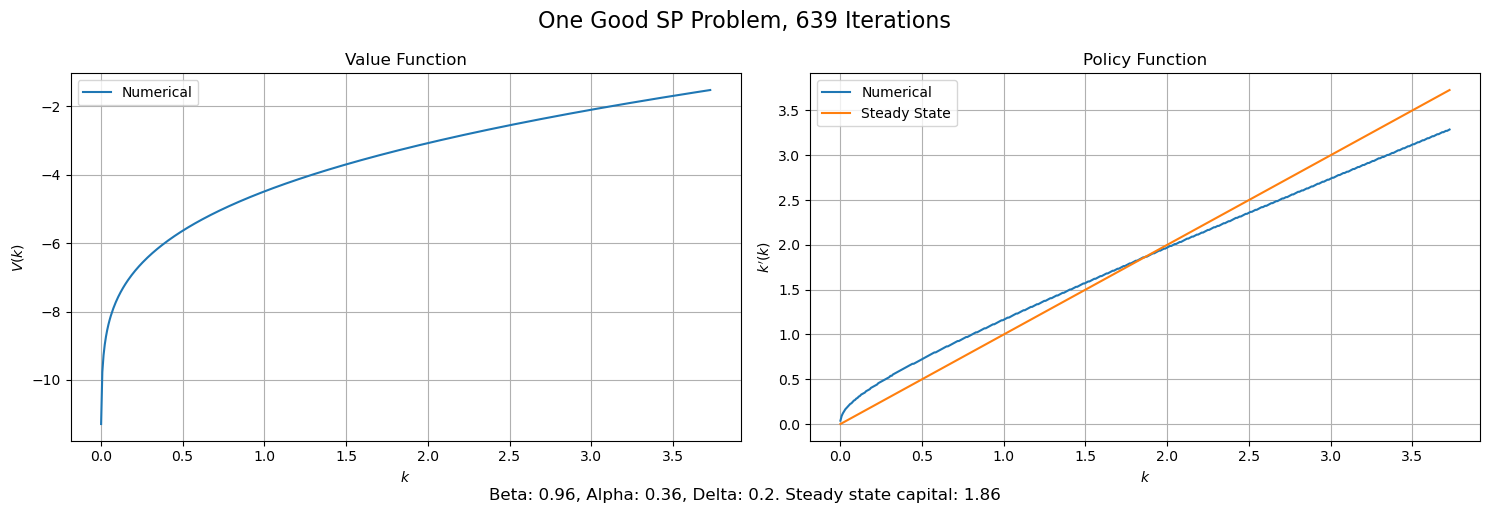

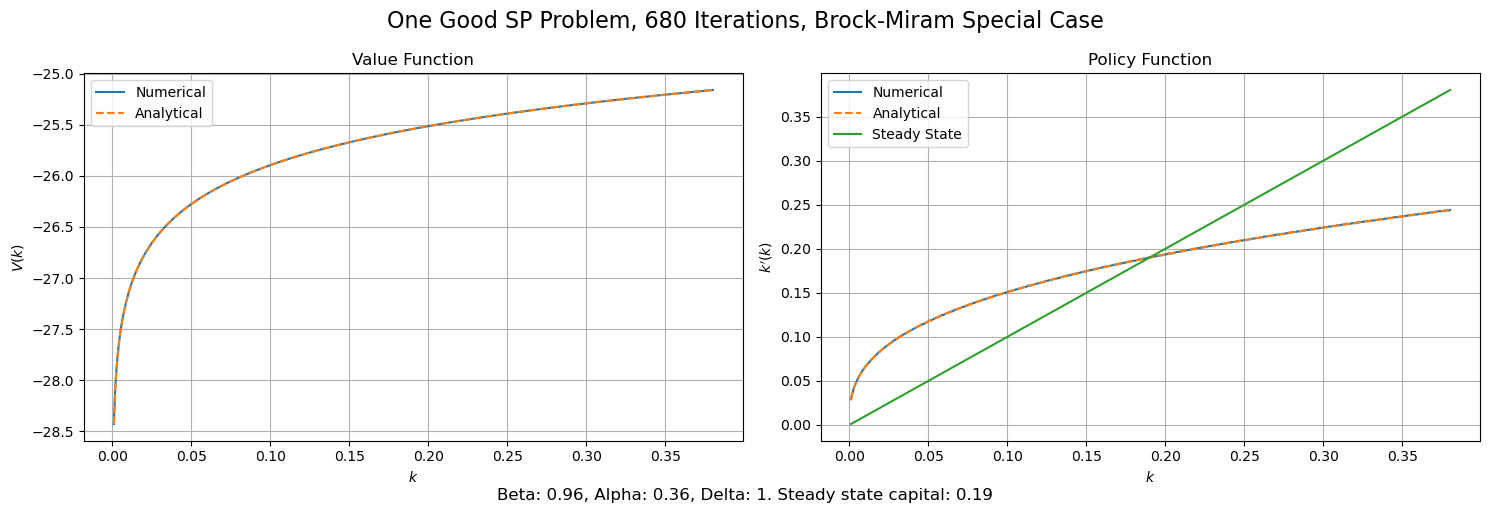

In [4]:
from numba import njit

@njit
def compute_utility_matrix(grid_size, k_grid, alpha, delta):
    # create a 2-D array, i for k, j for k'
    U = np.full((grid_size, grid_size), -1e10)  # Use a larger negative number
    # loop over the capital grid
    for i in range(grid_size):
        # calculate current recources 
        resources = (1-delta) * k_grid[i] + k_grid[i]**alpha
        for j in range(grid_size):
            if k_grid[j] <= resources:
                # calculate the utility
                U[i, j] = np.log(resources - k_grid[j])
            
    return U 
    
    
@njit  
def VFI_OneGood(V_initial, utility_matrix, beta, threshold, grid_size):
    
    # initilise the value funtion loop
    error = 10 + threshold
    V_old = V_initial
    iteration = 0
    V_new = np.zeros(grid_size)
    k_next_index = np.zeros(grid_size, dtype = np.int64)
    
    # do the value function iteration
    while error > threshold:
        # loop over states
        for i in range(grid_size):
            # initialise some values 
            max_value = -10e10
            max_index = 0
            # loop over next states
            for j in range(grid_size):
                # calculate the value
                value = utility_matrix[i, j] + beta * V_old[j]
                # check if the value is larger than the max
                if value > max_value:
                    max_value = value
                    max_index = j
            # assign max value to the value function
            V_new[i] = max_value
            # assign the index of the next state to the policy function index
            k_next_index[i] = max_index
        # check for convergence
        error = np.max(np.abs(V_new - V_old))
        # update the value function
        V_old = V_new.copy()
        # increase the iteration count
        iteration += 1
    # return the value function, policy function index and iteration count    
    return V_new, k_next_index, iteration




# create a class for the one-good with  SP problem
class OneGood_SP:
    def __init__(self, grid_size, capital_grid_multiple, beta=0.96, alpha=0.36, delta=0.1, threshold = 1e-12):
        
        # save parameters
        self.grid_size = grid_size
        self.capital_grid_multiple = capital_grid_multiple
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.threshold = threshold

        # SS capital
        self.k_ss = ( self.alpha / ( beta**(-1)+self.delta - 1) )**(1/(1-self.alpha))

        # create the grid for capital
        self.k_grid = np.linspace(1e-3, capital_grid_multiple*self.k_ss, grid_size)

        # create the utility matrix
        self.U = None

        # initialise the value function 
        self.V_initial = np.zeros(grid_size)

        # placeholders for outputs
        self.V = None
        self.k_next = None
        self.l = None
        self.iterations = None

    # define the VFI solver 
    def solve(self):
        # create the utility matrix
        self.U = compute_utility_matrix(self.grid_size, self.k_grid, self.alpha, self.delta)
        # call on globallly defined VFI function which uses njit
        V_final, k_next_index_final, iteration_final = VFI_OneGood(self.V_initial, self.U, self.beta, self.threshold, self.grid_size)
        # update relevant attributes
        self.V = V_final
        self.k_next = self.k_grid[k_next_index_final]
        self.iterations = iteration_final

    def plot(self):
        
        # initialise the figure of 3 plots
        fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
        # plot the value function
        axs[0].plot(self.k_grid, self.V, label='Numerical')
        # if brock-miram plot the analytical value function
        if self.delta == 1:
            # normalise value function
            i_match = np.argmax(self.k_grid)
            value_comp = self.alpha/(1-self.alpha*self.beta) * np.log(self.k_grid)
            offset = self.V[i_match] - value_comp[i_match]  # shift both to agree at end
            V_analytical_shifted = value_comp + offset
            axs[0].plot(self.k_grid, V_analytical_shifted, '--', label='Analytical')
        axs[0].set_title('Value Function')
        axs[0].set_xlabel(r"$k$")
        axs[0].set_ylabel(r"$V(k)$")
        axs[0].legend()
        axs[0].grid()
        
        # plot the policy function
        axs[1].plot(self.k_grid, self.k_next, label='Numerical')
        # if brock-miram plot the analytical policy function
        if self.delta == 1:
            axs[1].plot(self.k_grid, self.alpha * self.beta * self.k_grid**self.alpha, '--', label='Analytical')
        # plot the steady state intercept line
        axs[1].plot(self.k_grid, self.k_grid, label='Steady State')
        axs[1].set_title('Policy Function')
        axs[1].set_xlabel(r'$k$')
        axs[1].set_ylabel(r"$k'(k)$")
        axs[1].legend()
        axs[1].grid()

        # set title
        if self.delta == 1:
            fig.suptitle(f'One Good SP Problem, {self.iterations} Iterations, Brock-Miram Special Case', fontsize=16)
        else: 
            fig.suptitle(f'One Good SP Problem, {self.iterations} Iterations', fontsize=16)
        # subtitle
        fig.text(0.5, 0, f'Beta: {self.beta}, Alpha: {self.alpha}, Delta: {self.delta}. Steady state capital: {self.k_ss:.2f}', ha='center', fontsize=12)
        plt.tight_layout()
        plt.show()
    
# create an instance of the class
one_good = OneGood_SP(500, 2, 0.96, 0.36, 0.2)
one_good.solve()
one_good.plot()
# create an instance of the class with analytical comparison
one_good_brock = OneGood_SP(500, 2, 0.96, 0.36, 1)
one_good_brock.solve()
one_good_brock.plot()




How extraordinary! We have computed a solution to a non-trivial economic problem. In fact, because of the equivalence between the social planner problem and the competitive equilibrium, we have actually also solved for the allocation in both cases. This is a point we will come back to. 

The value function has the shape we would expect given the log utility function. In the case where $\delta = 1$, we actually can compare the numerical solution to the analytical known solution. We can see that this approximation virtually delivers the analytical solution. Where $k'(k)$ crosses the $y=x$ line, capital is in its steady state period-to-period. At this point, the SP has no incentive to invest in extra productive capacity or to "downsize" and consume less. To simulate the economy, we simply have to supply a starting state, $k_0$. 

### A Stochastic Economy

Really, the beauty of dynamic programming/recursive methods is its ability to deal with stochastic processes in an equilibrium way. For a long time, and even to this day, equilibrium was thought about as a system at rest. This clearly runs into problems if you allow a shock process to hit an economy. Fear no more.

Imagine that the production function is now $z_t F(k_t)$, where $z_t \in \{z_0, z_1\}:z_0<z_1, \, z_1, z_2>0$. In words, there are two states of productivity, low and high. Suppose that the process is a Markov process described by the transition matrix $\mathbf{P} \in \mathbb{R}^{2 \times 2}$. The $(i,j)$ th entry in the matrix is the probability that the Markov process transitions from state $j$ to state $i$. The rest of the problem is identical. The Bellman equation is very similar. Current resources are now, $f(k_t, z_t) = z_t F(k_t)+(1-\delta)k_t$. So, high productivity enlarges the feasible set.

$$V(k, z)= \max_{k' \in [0,f(k)]} \bigg\{ u(f(k,z)-k')+\beta \mathbb{E}[V(k',z')|z] \bigg\}$$

The striking fact is how similar the Bellman equation look in the deterministic and stochastic cases. In fact, $\mathbb{E}[V(k',z')|z] : (z, k') \to \mathbb{R}$. Simply put, tomorrow's value function is just a function of a state ($z$, which is known) and a control ($k'$, which we pick). Really, we just need the decision maker to be able to compute expectations properly. That is, the decision maker must know the structure of the economy, chiefly $\mathbf{P}$. This is tied to rational expectations, and is why rational expectations are a consistency axiom; agents' probability matrix is the true one. Tom Sargent often says that the appeal of this is dimensionality reduction. If we introduced a wedge between the decision makers $\mathbf{P}$ and the true $\mathbf{P}$, these parameters would be "free"---not restricted by anything.

As last time, we face a practical question: how should we choose the upper bound when we discretise the grid? One simple approach is to compute the steady state capital in the good state, when there a greater resources for capital investment. Getting the EE in exactly the same way.

$$ u_c(f(k,z)-k') = \beta u_c(f(k',z)-k'')f_{k'}(k',z)$$

This gives: 

$$1 = \beta ( 1 - \delta + \alpha z_{1,ss} k_{1,ss}^{\alpha-1} )$$

Very similarly to last time: 

$$k_{1,ss} = (\frac{\alpha z_{1,ss}}{\beta^{-1}+\delta-1})^{\frac{1}{1-\alpha}}$$

Before we solve in the exact same way as before, it may be useful to spell out exactly how we will treat the expectation. 

- When $z = z_0$, then $\mathbb{E}[V(k',z')|z] = P_{0,0} V(k',z_0)+P_{0,1} V(k',z_1)$
- When $z = z_1$, then $\mathbb{E}[V(k',z')|z] = P_{1,0} V(k',z_0)+P_{1,1} V(k',z_1)$

Let's solve just as before. Even though my example is of two stochastic states, we will write the code to be robust for multiple states where $\mathbb{E}[V(k',z')|z] = \sum_{z'} P_{z,z'}V(k',z')$. 

This is where we start to run into our first serious computation. Our value/policy functions are now 2D matrices. The utility matrix is 3D. In order to improve computation we will not guess $V_0(z,k) = 0$, which is quite a silly guess. Instead we will assume that today's available resources are consumed today and forever. This guess is obviously too high, as resources are not depleted.But it gives us a reasonable guess, especially as to the shape of the value function. That is $V_0(k,z) = \frac{u(f(k,z))}{1-\beta}$.

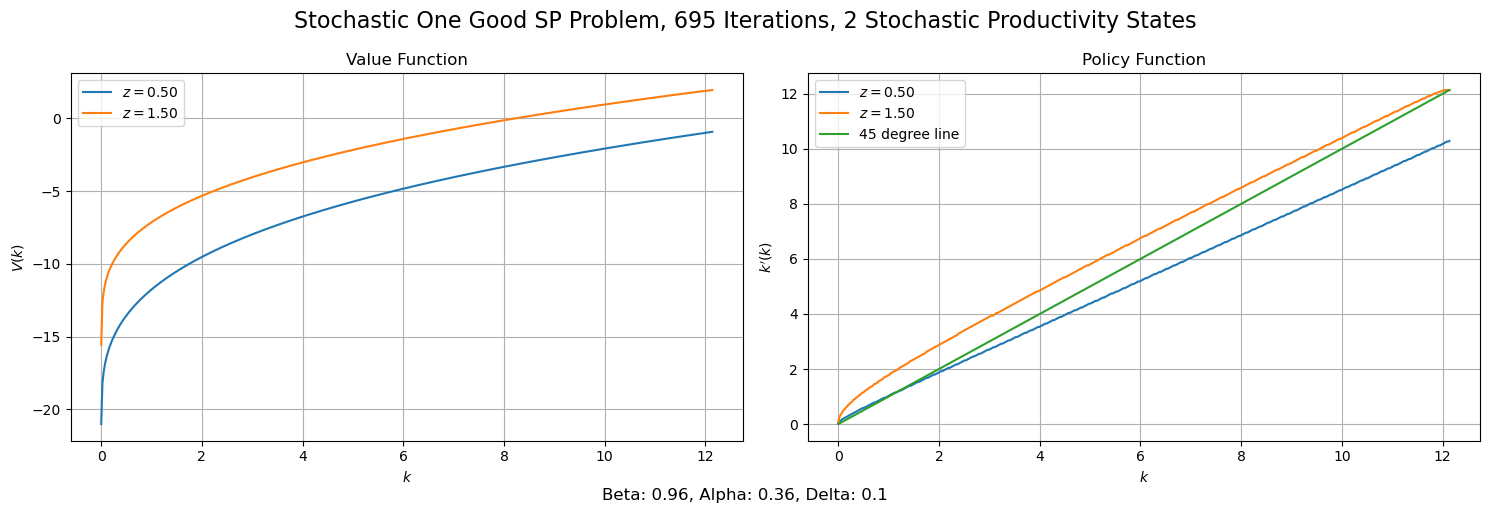

In [5]:
# define an "intelligent" value function initial guess
@njit
def V_initial_guess(k_grid, z_grid, alpha, beta, delta):
    # create a 2-D array, i for k, j for z
    k_grid_size = k_grid.shape[0]
    z_grid_size = z_grid.shape[0]
    V_0 = np.zeros((k_grid_size, z_grid_size))
    # loop over capital
    for i in range(k_grid_size):
        # loop over productivity
        for j in range(z_grid_size):
            # calculate the initial value if all resources are consumed
            V_0[i,j]= np.log(z_grid[j]*(k_grid[i]**alpha)+(1-delta)*k_grid[i])
    # dont forget to scale by 1-beta
    V_0 = V_0/(1-beta)
    # return the guess 
    return V_0


# define a function which creates the utility matrix 
@njit
def compute_utility_matrix_2stoch(z_grid, k_grid, alpha, delta):
    # create a 3-D array, i for k, j for z, and l for k'
    # initialise with -1e10
    k_grid_size = k_grid.shape[0]
    z_grid_size = z_grid.shape[0]
    U = np.full((k_grid_size, z_grid_size, k_grid_size), -1e10)
    # loop over the capital grid
    for i in range(k_grid_size):
        # loop over the z grid
        for j in range(z_grid_size):
            # resources in the current state 
            resources = z_grid[j]*k_grid[i]**alpha + (1-delta)*k_grid[i]
            # loop over the next capital grid
            for l in range(k_grid_size):
                # check if the next capital grid is less than resources
                if k_grid[l] <= resources:
                    # calculate the utility
                    U[i, j, l] = np.log(resources - k_grid[l])
    # return the matrix
    return U


# define a function which does the VFI for the 2 state problem
@njit
def VFI_2stoch(V_initial, utility_matrix,  k_grid, z_grid, transition, beta, threshold):
    # reminder, i for k, j for z, l for k'
    # initialise VFI
    error = 1 + threshold
    V_old = V_initial
    iteration = 0
    # get the grid sizes
    k_grid_size = k_grid.shape[0]
    z_grid_size = z_grid.shape[0]
    # start the value function iteration 
    while error > threshold: 
        # initialise matrices to be V(k,z), k'(k,z)
        V_new = np.zeros((k_grid_size, z_grid_size))
        k_next = np.zeros((k_grid_size, z_grid_size))
        # loop over capital today
        for i in range(k_grid_size):
            # loop over z grid 
            for j in range(z_grid_size):
                # initialise some helper variables to help you find the max/argmax (njit friendly)
                max_value = -1e10
                max_index = 0
                # loop over k' choices
                for l in range(k_grid_size):
                    # calculate the utility of that (k,z,k') configuration
                    # this is the key new step with a stochastic z process, first calculate ex_value
                    ex_value = np.dot(transition[j,:], V_old[l,:])
                    # now to full calculation
                    value = utility_matrix[i,j,l]+beta*ex_value
                    # record max args if an improvement has been made
                    if value > max_value:
                        max_value = value
                        max_index = l
                # assign to the value function 
                V_new[i,j] = max_value
                # assign to the policy function
                k_next[i,j] = k_grid[max_index]
        # check for convergence 
        error = np.max(np.abs(V_new - V_old))
        # move the iteration forward
        iteration += 1
        # lastly update the value function 
        V_old = V_new.copy()
    # return the objects of interest
    return V_new, k_next, iteration 
    

# define a class for the stochastic one good SP problem  
class Stoch_OneGood_SP:
    
    def __init__(self, capital_grid_size, prod_grid, transition_matrix, capital_grid_multiple=1.5, beta=0.96, alpha=0.36, delta=0.1, threshold = 1e-12):
        
        # save parameters
        self.capital_grid_size = capital_grid_size
        self.prod_grid = prod_grid
        self.transition_matrix = transition_matrix
        self.capital_grid_multiple = capital_grid_multiple
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.threshold = threshold

        # ss capital in best state 
        self.k_ss_best = ( self.alpha * np.max(prod_grid) / ( beta**(-1)+self.delta - 1) )**(1/(1-self.alpha))

        # create the grid for capital
        self.k_grid = np.linspace(1e-3, capital_grid_multiple*self.k_ss_best, capital_grid_size)

        # create the utility matrix
        self.U = None

        # initialise the value function "intelligently"
        self.V_initial = V_initial_guess(self.k_grid, prod_grid, alpha, beta, delta)

        # placeholders for outputs
        self.V = None
        self.k_next = None
        self.iterations = None

    # define the VFI solver
    def solve(self):
        # create the utility matrix
        self.U = compute_utility_matrix_2stoch(self.prod_grid, self.k_grid, self.alpha, self.delta)
        # call on globally defined VFI function which uses njit
        V_final, k_next_final, iteration_final = VFI_2stoch(self.V_initial, self.U, self.k_grid, self.prod_grid, self.transition_matrix, self.beta, self.threshold)
        # update relevant attributes
        self.V = V_final
        self.k_next = k_next_final
        self.iterations = iteration_final

    # plot the value function and policy function
    def plot(self):
        
        # initialise the figure of 2 plots
        fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
        # plot the value function
        for i in range(self.prod_grid.shape[0]):
            axs[0].plot(self.k_grid, self.V[:,i], label=fr"$z={self.prod_grid[i]:.2f}$")
        axs[0].set_title('Value Function')
        axs[0].set_xlabel(r"$k$")
        axs[0].set_ylabel(r"$V(k)$")
        axs[0].legend()
        axs[0].grid()
        
        # plot the policy function
        for i in range(self.prod_grid.shape[0]):
            axs[1].plot(self.k_grid, self.k_next[:,i], label=fr"$z={self.prod_grid[i]:.2f}$")
        # plot the steady state intercept line
        axs[1].plot(self.k_grid, self.k_grid, label='45 degree line')
        axs[1].set_title('Policy Function')
        axs[1].set_xlabel(r'$k$')
        axs[1].set_ylabel(r"$k'(k)$")
        axs[1].legend()
        axs[1].grid()

        # set title
        fig.suptitle(f'Stochastic One Good SP Problem, {self.iterations} Iterations, {self.prod_grid.shape[0]} Stochastic Productivity States', fontsize=16)
        # subtitle
        fig.text(0.5, 0, f'Beta: {self.beta}, Alpha: {self.alpha}, Delta: {self.delta}', ha='center', fontsize=12)
        plt.tight_layout()
        plt.show()

# create a stochastic productivity grid
z_grid = np.array([0.5, 1.5])
# create a transition matrix
transition_matrix = np.array([[0.9, 0.1], [0.3, 0.7]])
# create an instance of the class
two_shock_model = Stoch_OneGood_SP(500, z_grid, transition_matrix, 1.5, 0.96, 0.36, 0.1)
two_shock_model.solve()
two_shock_model.plot()

This is as one would expect. When in the good state of the world, the value function is higher, as is capital investment. We can see an insurance motive. Invest in captial in the good times and draw down on the capital stock in the bad times. Again, it is quite remarkable that though stochastic shocks hit the system, the social planner is making an equilibrium choice. 

## Ex 3: Optimal Stopping: When should I accept an offer on my house?

So far, we have considered "classic" problems in economics. For example, once you add a labour decision to the stochastic one-good problem you arrive at the famous Real Business Cycle Model (RBC). This model is associated most closely with Edward Prescott and Finn Kydland. These models explain business cycle fluctuations as real phenomena, as a result of productivity shocks as opposed to monetary or financial policy. I love macro, so I love these problems. However, the other day my mother asked me how dynamic programming is even useful. My parents are currently in the process of selling their house. My mother said, "why not write some code for that?" Challenge accepted. A mother's wisdom is worth taking seriously; students of dynamic programming should know that they are gaining very applicable skills.

Suppose that every period, my parents receive an offer for ths house $w_t \geq 0$. The distribution is mixed. $\lambda \in (0,1)$. 

$$w_t \sim  \begin{cases} 0 \text{ with probability } \lambda \\ \text{i.i.d draw from } F \text{ with probability } 1-\lambda \end{cases}$$

$F$ will have some conditions, such as the it not being able to be negative: my parents are not going to pay to offload their house! The core of this problem is that it is costly to have your house for sale. You have to continue to pay the mortgage, maintenace, and the estate agents. Suppose that every period the cost of keeping the house on the market is $c>0$. Nevertheless, given the distribution of expected offers, you musn't simply accept any offer. Suppose that if my parents accept an offer $w_t$ they keep the whole amount and do not pay $c$ that period, the buyer does. As before, $\beta \in (0,1)$. Let's Bellmanise the problem. 

$$V(w) = \max \bigg\{ w, \beta \mathbb{E}[V(w')] - c \bigg\}$$

A key point here is that you make the decision *after* seeing the offer $w$. That is why it is a state variable. As usual, we need to call on SLP to figure out if this is a valid Contraction mapping and that $V$ does live in the space of bounded and continuous functions. [INSERT SLP CONDITIONS HERE].

The important feature about this problem, and many others like it such as job search models, is that there is a reservation offer. The right-hand side of the max operator is some constant which does not depend on $w$. The decision maker will accept the offer $w$ only if it is greater or equal to that reservation wage. This means that the functional form of the value function is known. $V(w) = \max \{w, r\}$, where $r$ is the unknown reservation wage. The key therefore becomes solving the fixed point problem:

$$r = \beta E[\max\{w',r\}]-c$$

This seemingly innocuous expression is a little trickier that one might think. The updating algorithm therefore becomes,

$$r_{new} = \underbrace{\beta \lambda r_{old}}_{\text{No offer next period}} + \underbrace{\beta (1-\lambda) r_{old} F(r_{old})}_{\text{Offer below reservation rejected}}+  \underbrace{\beta (1-\lambda) (1- F(r_{old})) \mathbb{E}[w'|w'>r_{old}])}_{\text{Offer above reservation accepted}}-c$$

So, we iterate on a scalar. I will solve this example for two example distributions. Firstly, $F = U[\underline{w}, \bar{w}]$. Secondly, $F$ as a $\text{Beta}(\alpha, \beta)$ projected onto $[\underline{w}, \bar{w}]$.

It is worth spelling out how to scale the beta function a little more explicitly. Remember that the beta distribution if for random variables $b$ on the $[0,1]$ line. In order to scale it the way we want we need to transform it as such:

$$w = g(b) =  \underline{w} + (\bar{w}-\underline{w})b$$

Remember from our first encounters with probability that for a tranformation w(b) that $f_W(w) = f_B(g^{-1}(w)) \frac{d b}{d w}$. I have been a little lazy here as the tranformation is obviously monotonically positive. PDFs are the "tougher" ones to change between. CDFs are the straightforward ones. Now we can solve the problem for these two distributions.

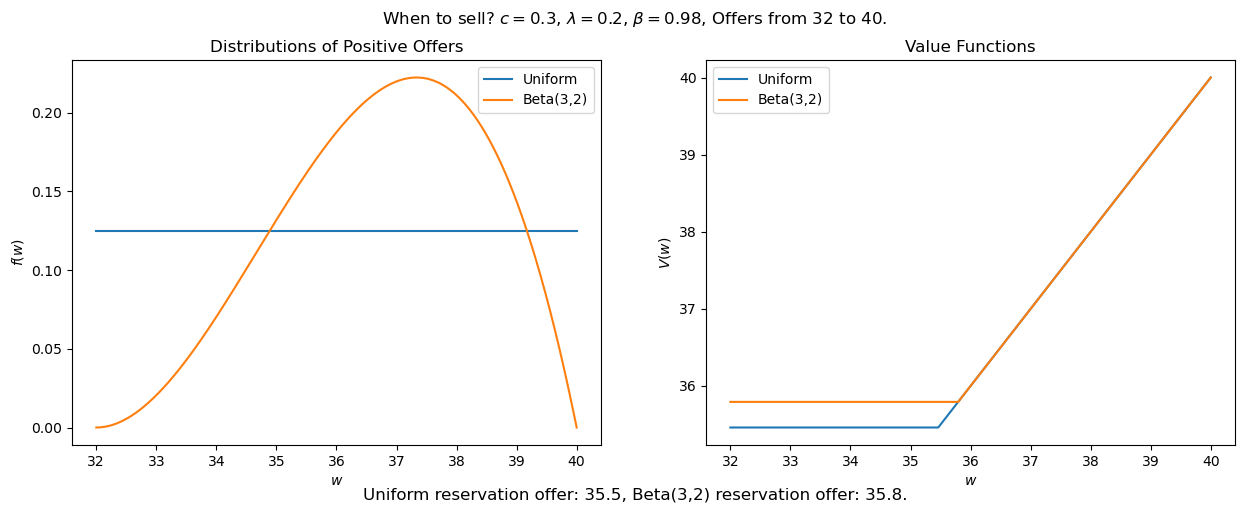

In [6]:
# initialise class for uniform
class Uniform:
    
    def __init__(self, w_min, w_max):
        
        self.w_min = w_min 
        self.w_max = w_max

    def CDF(self, r):
        # handle r<w_ min
        if r < self.w_min:
            return 0.0
        # handle r>w_max
        elif r > self.w_max:
            return 1.0
        # in range return CDF
        else:
            return (r-self.w_min)/(self.w_max - self.w_min)
        
    def PDF_plot(self, grid_size):
        # return PDF for plotting, easy for uniform
        return np.full(grid_size, 1/(self.w_max-self.w_min))

        
    def E_above_r(self, r):
        # handle r>w_max
        if r > self.w_max:
            return 0.0
        # give the genuine answer
        else:
            # if r<w_min then w_min is the relevant lower bound 
            r = max(r, self.w_min)
            # return the expected value if w>r
            return (self.w_max**2 - r**2)/(2*(self.w_max-r))
        
# import packages
from scipy.stats import beta
from scipy.integrate import quad
# initialise the class for the scaled beta
class ScaledBeta:

    def __init__(self, alpha_param, beta_param, w_min, w_max, integral_size = 1000):
        
        # initialise the parameters
        self.alpha_param = alpha_param
        self.beta_param = beta_param
        self.w_min = w_min
        self.w_max = w_max
        self.integral_size = integral_size

    # return the pdf to plot
    def PDF_plot(self,grid_size):
        # set up support
        supp = np.linspace(self.w_min, self.w_max, grid_size)
        # calculate pdf
        return beta.pdf((supp-self.w_min)/(self.w_max - self.w_min), self.alpha_param, self.beta_param)*(1/(self.w_max - self.w_min))

    # do the CDF
    def CDF(self, w):
        # clip w to be safe
        w = np.clip(w, self.w_min, self.w_max)
        # return the scaled CDF
        return beta.cdf( (w-self.w_min)/(self.w_max - self.w_min), self.alpha_param, self.beta_param)
    
    def E_above_r(self,r):
        # clip r
        r = np.clip(r, self.w_min, self.w_max)
        # set up a grid for approx
        w_grid = np.linspace(r, self.w_max, self.integral_size)
        # write the f_w(w) which I will have to integrate
        pdf_con_values = beta.pdf((w_grid-self.w_min)/(self.w_max - self.w_min), self.alpha_param, self.beta_param)*(1/(self.w_max - self.w_min))
        # now write the full integrand
        integrand = w_grid * pdf_con_values
        # approx integral
        integral = np.trapz(integrand, w_grid)
        # compute the scaling factor
        scale = 1 - beta.cdf((r - self.w_min) / (self.w_max - self.w_min), self.alpha_param, self.beta_param)
        # return the scaled integral
        return integral/scale
    

# create class for house offer problem
class HouseOffer:

    # initialise the class
    def __init__(self, c, lambda_, beta, distribution, tolerance = 1e-12):

        # assign the variables
        self.c = c
        self.lambda_ = lambda_
        self.beta = beta
        self.distribution = distribution
        self.tolerance = tolerance

        # catcher variables
        self.r_final = None
        self.iterations = None

    def solve(self):

        # initialise error
        error = 1 + self.tolerance
        # guess r_0 as the midpoint of wages
        r_old = (self.distribution.w_max+self.distribution.w_min)/2
        # set up counter
        iterations = 0 
        # set up the loop 
        while error > self.tolerance:
            # get the cdf of r_old
            cdf_r = self.distribution.CDF(r_old)
            # get the ex value above cond on w>r
            E_above_r = self.distribution.E_above_r(r_old)
            # update the reservation wage guess
            r_new = self.beta * self.lambda_*r_old + self.beta*(1-self.lambda_)*r_old*cdf_r+self.beta*(1-self.lambda_)*(1-cdf_r)*E_above_r-self.c
            # check for almost convergance
            error = np.abs(r_new - r_old)
            # add to count
            iterations += 1
            # finally update old reservation
            r_old = r_new 

        # store the outputs as attributes
        self.r_final = r_new 
        self.iterations = iterations

# initialise the pars
min_offer = 32
max_offer = 40 
c = 0.3
lambda_ = 0.2
beta_value = 0.98

# initialise some example distributions
plot_grid_size = 1000
uniform_ex = Uniform(min_offer, max_offer)
scaled_beta_ex = ScaledBeta(3, 2, min_offer, max_offer)

# now for the fun stuff, initialise the classes
unif_house = HouseOffer(c, lambda_, beta_value, uniform_ex)
beta_house = HouseOffer(c, lambda_, beta_value, scaled_beta_ex)
unif_house.solve()
beta_house.solve()


# plot the distributions
w_vals = np.linspace(min_offer, max_offer, plot_grid_size)
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(w_vals, uniform_ex.PDF_plot(plot_grid_size), label = 'Uniform')
ax[0].plot(w_vals, scaled_beta_ex.PDF_plot(plot_grid_size) ,label = f'Beta({scaled_beta_ex.alpha_param},{scaled_beta_ex.beta_param})')
ax[0].set_title('Distributions of Positive Offers')
ax[0].set_xlabel(r'$w$')
ax[0].set_ylabel(r'$f(w)$')
ax[0].legend()
ax[1].plot(w_vals, np.maximum(w_vals, np.full(plot_grid_size, unif_house.r_final)), label = 'Uniform')
ax[1].plot(w_vals, np.maximum(w_vals, np.full(plot_grid_size, beta_house.r_final)), label = f'Beta({scaled_beta_ex.alpha_param},{scaled_beta_ex.beta_param})')
ax[1].set_title("Value Functions")
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$V(w)$')
ax[1].legend()
fig.text(0.5, 0, f'Uniform reservation offer: {unif_house.r_final:.1f}, Beta({scaled_beta_ex.alpha_param},{scaled_beta_ex.beta_param}) reservation offer: {beta_house.r_final:.1f}.', ha='center', fontsize=12)
fig.suptitle(fr'When to sell? $c=${c}, $\lambda=${lambda_}, $\beta=${beta_value}, Offers from {min_offer} to {max_offer}.')
plt.show()


These charts show (1) the distribution of offers conditional on being greater than zero (2) the value functions under the two distributions. The reservation offer completely descibes the optimal strategy in this case. This is the case of a *threshold strategy*. These pop up everywhere in economics. In this case, my parents' policy function should be: 

$$\sigma(w) = \begin{cases} \text{Accept if } w < r \\ \text{Reject if } w \geq r \end{cases}$$

$r$ is exactly what we have approximated, and is the point at which there is a kink in the value function. For the two cases studied, the reservation offers are reported at the bottom of the plots. At and beyond $r$, we value the problem/house as much as $w$ because we accept the offer. Below $r$, $r$ is the value of the problem/house because $r=\beta E[V(w')]-c$ is the payoff we expect if we continue (i.e. we reject the offer and move to the next period). It is often called the *continuation value*.

The biggest drawback of this example is that we take the offers as exogeneous. Surely there is some reason that offers have a particular schedule. But for many problems, such as this, the tools we have developed so far do have useful implications. 

Thank you to my parents for motivating this example.

## A List of Problems

To wrap up this class, which should have showed the reader how to do VFI with grid discretisation well in deterministic and stochastic set-ups, I set out, and elaborate on, the list of "problems" we want to take to the next classes. 

1. Policy choices are constrained to the grid

In the examples where there is a continous control space (*Ex 1* and *Ex 2*), we constrained VFI to always choose policies which happen to fall exactly on the grid. This is unsatisfactory as the agent should be choosing over a continuous interval. Nevertheless, in the absence of a genuine function, this is reasoneble. We were approximating continuous functions as vectors/matrices. Perhaps there is a way we can assemble piece-wise continous functions to approximate continuous functions? Perhaps in doing this we can reduce drastically the number of grid points we compute in return for an approximate continuous function.

2. Even grid points

In *Ex1* and *Ex 2*, we discretised the state and control spaces by creating a grid with evenly spaced grid points. This is a safe first strategy. However, in *Ex 1* we saw that the numerical solution has the largest error where the value function has the most curvature, and that this error is visible in the graph. Can we have more grid points where there is high curvature and fewer where there is less?

3. Discrete Shocks as States

In *Ex 2*, we explored how to add a stochastic productivity shock as a discrete state to the one-good problem. If the stochastic process is Markov, this boils down to extracting the relevant row of the transition matrix to amend the Bellman equation. However, we are often interested in continuous stochastic state processes. We need a way to handle continuous shocks to open up a host of important economic problems.

4. RCE, Multiple Agents

Our examples so far have included only one decision-maker. In economics, we often care about the equilibrium interaction of multiple agents, e.g. between governments and bond holders, between consumers and producers, or employers and job searchers. To be more precise, when using recusrive methods we want to compute recursive competitive equilibria (RCE). An RCE is a collection value functions, policy functions, perceived laws of motion, and actual aggregate laws of motion which respect market clearing and a set of consistency conditions. As previously mentioned, sometimes we can solve the one-agent social planner problem and appeal to an equivalence between it and the RCE: we can invoke the Welfare Theorems. The social planner problem in *Ex 2* has such a RCE equivalent. Unfortunately, SLP show that only a small subset of equilibria of interest can be computed in this way. So, we will want to learn (1) how to use the method when it works (2) how to compute a RCE when it doesn't.



